# Data Preprocessing


- **Binning (Sum)**: All spectra are binned uniformly (sum) from range [100-1500] with step 0.02  
- **Normalization**: TIC



In [1]:
from pyimzml.ImzMLParser import ImzMLParser
import numpy as np
import random
import matplotlib.pyplot as plt
import math


p = ImzMLParser('../Data/LPS/Control1.imzml')

my_spectra = []
for idx, (x,y,_) in enumerate(p.coordinates):
    mzs, intensities = p.getspectrum(idx)
    my_spectra.append([mzs, intensities, (x, y)])

print(f"Total spectra loaded: {len(my_spectra)}")


c:\Users\mazar\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyimzml\ontology\ontology.py:80: UserWarning: Unrecognized accession in <cvParam>:  (name: "").
  warn('Unrecognized accession in <cvParam>: %s (name: "%s").' % (accession, raw_name))
c:\Users\mazar\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyimzml\ontology\ontology.py:92: UserWarning: Accession IMS:1000042 found with incorrect name "max count of pixel x". Updating name to "max count of pixels x".
  warn(
c:\Users\mazar\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyimzml\ontology\ontology.py:92: UserWarning: Accession IMS:1000043 found with incorrect name "max count of pixel y". Updating name to "max count of pixels y".
  warn(
c:\Users\mazar\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyimzml\ontology\ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)".
  warn(


Total spectra loaded: 1636


In [2]:
max_mz = -float('inf')
min_mz = float('inf')
for spectrum in my_spectra:
    max_mz = math.ceil(max(max(spectrum[0]),max_mz))
    min_mz = math.floor(min(min(spectrum[0]),min_mz))
print(f'Range of mz values:',(min_mz,max_mz))




Range of mz values: (150, 2000)


In [36]:
# Assuming `my_spectra` contains tuples of (mzs, intensities, (x, y)) where (x, y) are the coordinates of the spectrum.

# Define the range of x and y coordinates
x_coords = sorted(set(coord[0] for _, _, coord in my_spectra))
y_coords = sorted(set(coord[1] for _, _, coord in my_spectra))

# Create mappings from coordinates to indices
x_to_index = {x: i for i, x in enumerate(x_coords)}
y_to_index = {y: i for i, y in enumerate(y_coords)}

# Initialize the 3D array: k x p x m
common_mzs = np.arange(min_mz, max_mz, 0.02)
binned = np.zeros((len(x_coords), len(y_coords),len(common_mzs)), dtype=np.float32)

# Populate the 3D array
for mzs, intensities, (x, y) in my_spectra:
    x_idx = x_to_index[x]
    y_idx = y_to_index[y]
    indices = np.digitize(mzs, common_mzs) - 1
    for k, val in zip(indices, intensities):
        if 0 <= k < binned.shape[2]:
            binned[x_idx, y_idx, k] += val

# Normalize the intensities along the m-axis (summing over k)
tic = binned.sum(axis=2, keepdims=True)
tic[tic == 0] = 1

X = binned / tic

# Convert to float16 AFTER normalization (values are now 0-1 range)
X = X.astype(np.float16)

print(f"3D Matrix created!")
print(f"Matrix has dimensions of {X.shape}")

3D Matrix created!
Matrix has dimensions of (42, 40, 92500)


{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 24: 23, 25: 24, 26: 25, 27: 26, 28: 27, 29: 28, 30: 29, 31: 30, 32: 31, 33: 32, 34: 33, 35: 34, 36: 35, 37: 36, 38: 37, 39: 38, 40: 39}


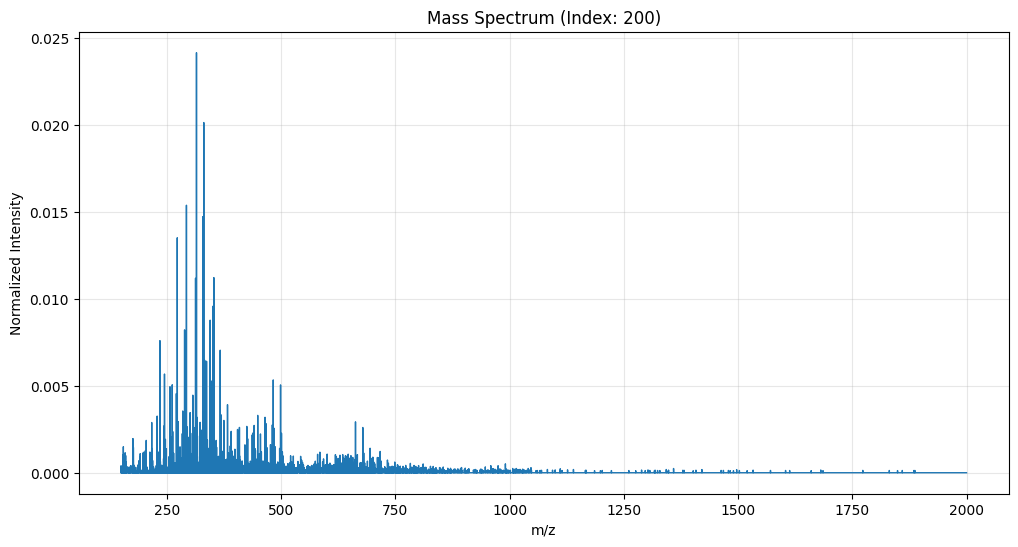

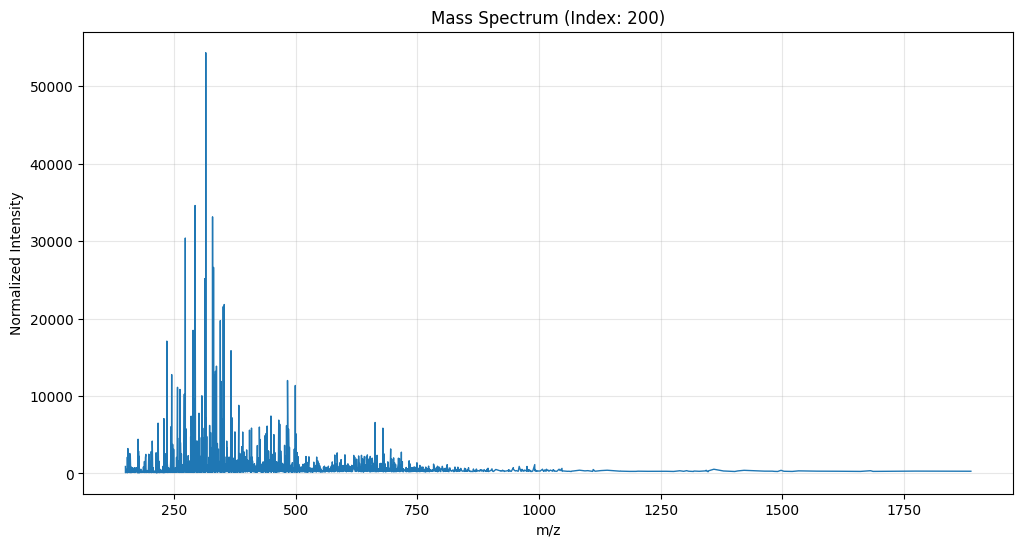

In [37]:
print(y_to_index)
# Plot a random spectrum
spectrum_idx = 200
plt.figure(figsize=(12, 6))
plt.plot(common_mzs, X[0][0], linewidth=1.0)
plt.xlabel('m/z')
plt.ylabel('Normalized Intensity')
plt.title(f'Mass Spectrum (Index: {spectrum_idx})')
plt.grid(True, alpha=0.3)
plt.show()

spectrum_idx = 200
plt.figure(figsize=(12, 6))
plt.plot(my_spectra[0][0], my_spectra[0][1], linewidth=1.0)
plt.xlabel('m/z')
plt.ylabel('Normalized Intensity')
plt.title(f'Mass Spectrum (Index: {spectrum_idx})')
plt.grid(True, alpha=0.3)
plt.show()

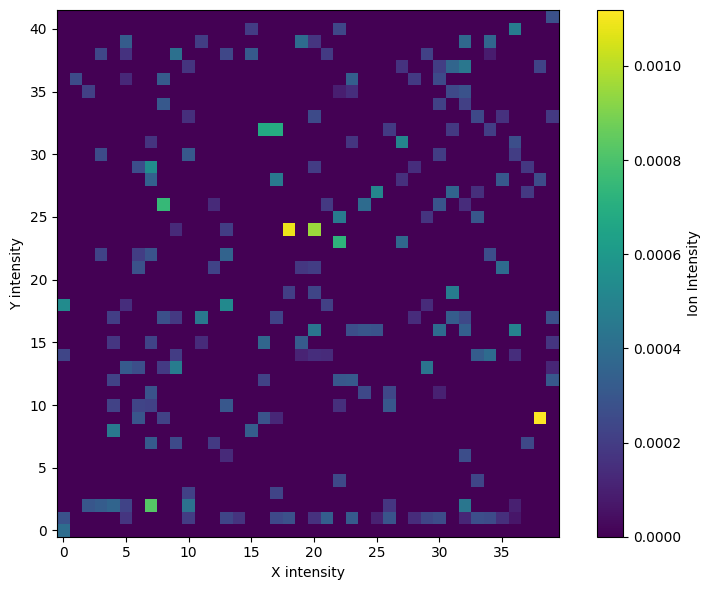

In [45]:
# Extract the slice of interest
slice_data = X[:, :, 0] + X[:,:,1]



# Create a scatter plot
# plt.figure(figsize=(10, 8))
# plt.scatter(
#     np.repeat(np.arange(slice_data.shape[1]), slice_data.shape[0]),  # x-coordinates (columns)
#     np.tile(np.arange(slice_data.shape[0]), slice_data.shape[1]),   # y-coordinates (rows)
#     c=slice_data.flatten(),                                         # color based on values
#     cmap='viridis',                                                 # colormap                                                           # marker size
# )
# plt.colorbar(label='Normalized Intensity')
# plt.xlabel('Pixel X Coordinate')
# plt.ylabel('Pixel Y Coordinate')
# plt.title('Scatter Plot of Pixel Intensities')
# plt.gca().invert_yaxis()  # Invert y-axis for correct orientation
# plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(slice_data, cmap='viridis', origin='lower')
plt.colorbar(label='Ion Intensity')
plt.xlabel("X intensity")
plt.ylabel("Y intensity")
plt.tight_layout()
plt.show()

42 41
Points found 11


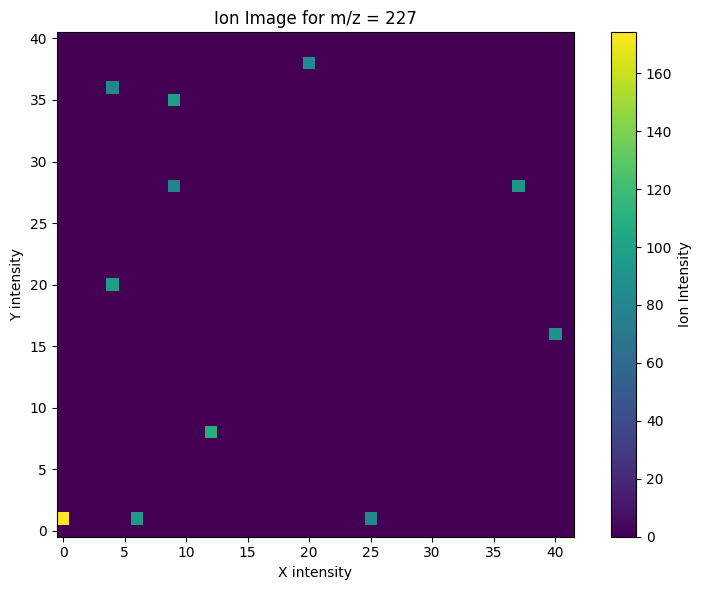

227.0000000000394 226.98000000003938 227.0200000000394


In [44]:

# Choose the m/z you want to plot  and tolerance
target_mz = 227
tolerance = 0.02

# Get image dimensions
all_coords = [coord for _, _, coord in my_spectra]
xs, ys = zip(*all_coords)
width = max(xs) + 1
height = max(ys) + 1
print(width,height)



# Create empty image
ion_image = np.zeros((height, width))

# Fill in the ion image with intensities for target m/z
times = 0 
for mzs, intensities, (x, y) in my_spectra:
    # Get mask of indices where mz is within target window
    mz_mask = (mzs >= target_mz - tolerance) & (mzs <= target_mz + tolerance)
    if np.any(mz_mask):
        times+=1
        ion_intensity = np.mean(intensities[mz_mask])
        ion_image[y, x] = ion_intensity
print(f"Points found", times)

# Plot the ion image
plt.figure(figsize=(8, 6))
plt.imshow(ion_image, cmap='viridis', origin='lower')
plt.colorbar(label='Ion Intensity')
plt.title(f"Ion Image for m/z = {target_mz}")
plt.xlabel("X intensity")
plt.ylabel("Y intensity")
plt.tight_layout()
plt.show()
print(common_mzs[3850],common_mzs[3849],common_mzs[3851])

In [ ]:
# Save the processed data to npy files
np.save('../Data/LPS/control1_x.npy', X)
# np.save('../Data/LPS/control1_mzs.npy', common_mzs)
# np.save('../Data/LPS/control1_coords.npy', [coord for _, _, coord in my_spectra])

